# Protein abundance change

This notebook runs the analyses on protein abundance changes between variant and reference alleles using Cell Painting assays

In [1]:
### imports
import os
import polars as pl
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from plot_utils import *
%matplotlib inline

PLATEMAP_DIR = "../2.snakemake_pipeline/inputs/metadata/platemaps/{batch_id}/platemap"
PROF_DIR = "../2.snakemake_pipeline/outputs/batch_profiles"
CLASS_RES_DIR = "../2.snakemake_pipeline/outputs/classification_analyses"
IMG_QC_DIR = "../../../../3_outputs/1_snakemake_pipeline/2.smp_results_analyses/1.image_qc_outputs/{bio_rep}"
GFP_FEAT = "Cells_Intensity_MeanIntensity_GFP" #"Cells_Intensity_IntegratedIntensity_GFP"

In [2]:
BIO_REP_BATCHES_DICT = {
    "2024_01_Batch_7-8": ("2024_01_23_Batch_7", "2024_02_06_Batch_8"),
    "2024_12_Batch_11-12": ("2024_12_09_Batch_11", "2024_12_09_Batch_12"),
    "2025_03_Batch_15-16": ("2025_03_17_Batch_15", "2025_03_17_Batch_16"),
    # "2025_01_Batch_13-14": ("2025_01_27_Batch_13", "2025_01_28_Batch_14")
}

BIO_BATCH_MAP_DICT = {
    "B7": "B_7-8",
    "B8": "B_7-8",
    "B11": "B_11-12",
    "B12": "B_11-12",
    "B15": "B_15-16",
    "B16": "B_15-16",
}

CLASS_RES_OUTDIR = "../../../../3_outputs/1_snakemake_pipeline/2.smp_results_analyses/2.cell_count_abundance_change"

## 1. Load Metadata

### 1.1 Meta allele data

In [3]:
allele_meta_df, img_well_qc_sum_df = pl.DataFrame(), pl.DataFrame()
allele_meta_df_dict, img_well_qc_sum_dict = {}, {}

for bio_rep, bio_rep_batches in BIO_REP_BATCHES_DICT.items():
    for batch_id in bio_rep_batches:
        allele_meta_df_batch = pl.DataFrame()
        platemaps = [file for file in os.listdir(PLATEMAP_DIR.format(batch_id=batch_id)) if file.endswith(".txt")]
        for platemap in platemaps:
            platemap_df = pl.read_csv(os.path.join(PLATEMAP_DIR.format(batch_id=batch_id), platemap), separator="\t", infer_schema_length=100000)
            allele_meta_df_batch = pl.concat([allele_meta_df_batch, 
                                        platemap_df.filter((pl.col("node_type").is_not_null()))], # (~pl.col("node_type").is_in(["TC","NC","PC"]))&
                                        how="diagonal_relaxed").sort("plate_map_name")
            allele_meta_df_batch = allele_meta_df_batch.with_columns(pl.col("plate_map_name").alias("plate_map")) ## str.split('_').list.get(0).
        allele_meta_df = pl.concat([
            allele_meta_df,
            allele_meta_df_batch
        ], how="diagonal_relaxed")#.sort("plate_map_name") ## (~pl.col("node_type").is_in(["TC","NC","PC"]))&
    allele_meta_df_dict[bio_rep] = allele_meta_df_batch

    img_well_qc_sum = pl.read_csv(f"{IMG_QC_DIR.format(bio_rep=bio_rep)}/plate-well-level_img_qc_sum.csv")
    img_well_qc_sum_morph = img_well_qc_sum.filter(pl.col("channel")!="GFP")
    img_well_qc_sum_morph = img_well_qc_sum_morph.group_by(["plate","well"]).agg(
        pl.col("is_bg").max().alias("is_bg"),
        pl.col("s2n_ratio").mean().alias("s2n_ratio"),
        pl.col("median_plate").mean().alias("median_plate"),
    ).with_columns(pl.lit("Morph").alias("channel"))
    img_well_qc_sum = pl.concat([
        img_well_qc_sum.select(pl.col(["plate","well","channel","median_plate","is_bg","s2n_ratio"])),
        img_well_qc_sum_morph.select(pl.col(["plate","well","channel","median_plate","is_bg","s2n_ratio"])),
    ], how="vertical_relaxed")
    
    img_well_qc_sum_df = pl.concat(
        [img_well_qc_sum_df, img_well_qc_sum],
        how="diagonal_relaxed"
    )
    img_well_qc_sum_dict[bio_rep] = img_well_qc_sum

In [4]:
tested_variants = allele_meta_df.filter((pl.col("gene_allele").is_not_null())&(pl.col("node_type")=="allele")).unique(subset=["gene_allele"])["gene_allele"]
len(tested_variants)

865

## 2. CellProfiler Features

### Get the CP features for cells that passed the QC

In [5]:
pass_qc_prof_dir = "{}/{}/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells.parquet"
cell_alleles = pl.DataFrame()

for bio_rep, bio_rep_batches in BIO_REP_BATCHES_DICT.items():
    combined_profiles_batch = pl.DataFrame()
    for batch_id in bio_rep_batches:
        # Get meta features
        batch_alleles = (
            pl.scan_parquet(
                pass_qc_prof_dir.format(PROF_DIR, batch_id)
            )
            # .filter(pl.col("Metadata_gene_allele").is_in(all_alleles))
            .with_columns(
                pl.concat_str(
                    [
                        "Metadata_Plate",
                        "Metadata_Well",
                        "Metadata_ImageNumber",
                        "Metadata_ObjectNumber",
                    ],
                    separator="_",
                ).alias("Metadata_CellID")
            )
            .select([
                "Metadata_CellID",
                "Metadata_gene_allele",
                "Metadata_Well",
                "Metadata_Plate",
            ])
        )
        combined_profiles_batch = pl.concat([combined_profiles_batch, batch_alleles.collect()]) 
        
    cell_alleles = pl.concat([cell_alleles, combined_profiles_batch])

### Get the Cells_Intensity CP features per all cells

Merge the Cells_Intensity features to the pass-QC cells

In [6]:
combined_gfp_profiles = pl.DataFrame()

for bio_rep, bio_rep_batches in BIO_REP_BATCHES_DICT.items():
    combined_profiles_batch = pl.DataFrame()
    for batch_id in bio_rep_batches:
        # Get meta features
        batch_gfp_prof = (
            pl.scan_parquet(
                f"{PROF_DIR}/{batch_id}/profiles.parquet"
            ).with_columns(
                pl.concat_str(
                    [
                        "Metadata_Plate",
                        "Metadata_Well",
                        "Metadata_ImageNumber",
                        "Metadata_ObjectNumber",
                    ],
                    separator="_",
                ).alias("Metadata_CellID")
            )
        )
        gfp_int = [i for i in batch_gfp_prof.collect_schema().names() if "Cells_Intensity" in i]
        gfp_int = ["Metadata_CellID"] + [i for i in gfp_int if "GFP" in i]
        combined_gfp_profiles = pl.concat([
            combined_gfp_profiles, 
            batch_gfp_prof.select(gfp_int).collect()
        ])

profiles = cell_alleles.join(combined_gfp_profiles, on="Metadata_CellID", how="left")

### Aggregate the cells to well profiles

In [7]:
well_profiles = (
    profiles.group_by(["Metadata_Plate", "Metadata_Well", "Metadata_gene_allele"])
    .agg(
        pl.col(col).median().alias(col)
        for col in profiles.columns
        if not col.startswith("Metadata_")
    )
    # .filter(pl.col("Metadata_gene_allele").is_in(balanced_class_alleles))
    .unique()
)

img_well_qc_sum_gfp = img_well_qc_sum_df.filter(pl.col("channel")=="GFP").with_columns(
    pl.col("plate").alias("Metadata_Plate"),
    pl.col("well").alias("Metadata_Well"),
)

well_profiles = well_profiles.join(
    img_well_qc_sum_gfp,
    on=["Metadata_Plate","Metadata_Well"],
    how="left"
).with_columns(
    pl.col("Metadata_Plate").str.extract(r"(B[^A]*)", 1).replace(BIO_BATCH_MAP_DICT).alias("Metadata_Bio_Batch")
)
print("Original image wells:", well_profiles.shape)

Original image wells: (11788, 25)


In [8]:
well_profiles = well_profiles.filter(~pl.col("is_bg"))
print("Image wells after QC based on GFP:", well_profiles.shape)

Image wells after QC based on GFP: (10795, 25)


In [14]:
# def plot_gfp_per_plate(well_profile_df, gfp_feat="Cells_Intensity_IntegratedIntensity_GFP"):
#     plate_maps = set(["_".join(plate_map.split("_")[:-1]) for plate_map in sorted(well_profile_df["Metadata_Plate"].unique())])
#     for plate_map in plate_maps:
#         plate_map_cc = well_profile_df.filter(pl.col("Metadata_Plate").str.contains(plate_map))
#         plates = sorted(plate_map_cc["Metadata_Plate"].unique().to_list())
#         fig, axes = plt.subplots(2,2,figsize=(48,23)) ## sharey=True,sharex=True
#         for plate in plates:
#             plate_info = plate_map_cc.filter(pl.col("Metadata_Plate")==plate)
#             # display(plate_info.filter(pl.col("is_bg")))
#             # print(plates.index(plate))
#             plot_platemap(
#                 plate_info,
#                 plate,
#                 well_pos_col="Metadata_Well",
#                 # this is the column to color by (categorical or continuous)
#                 value_col=gfp_feat,
#                 # these columns will be concatenated into the annotation text
#                 label_cols=("Metadata_gene_allele",gfp_feat),
#                 ax=axes[plates.index(plate)//2, plates.index(plate)%2],
#                 value_type="continuous",   # or "continuous"
#                 continuous_cmap="vlag",  # matplotlib colormap for continuous mode
#                 grid_square=None
#             )
#         fig.subplots_adjust(wspace=-.55, hspace=.05)
#         plt.tight_layout()
#         plt.show()

# plot_gfp_per_plate(well_profiles)

<Figure size 640x480 with 0 Axes>

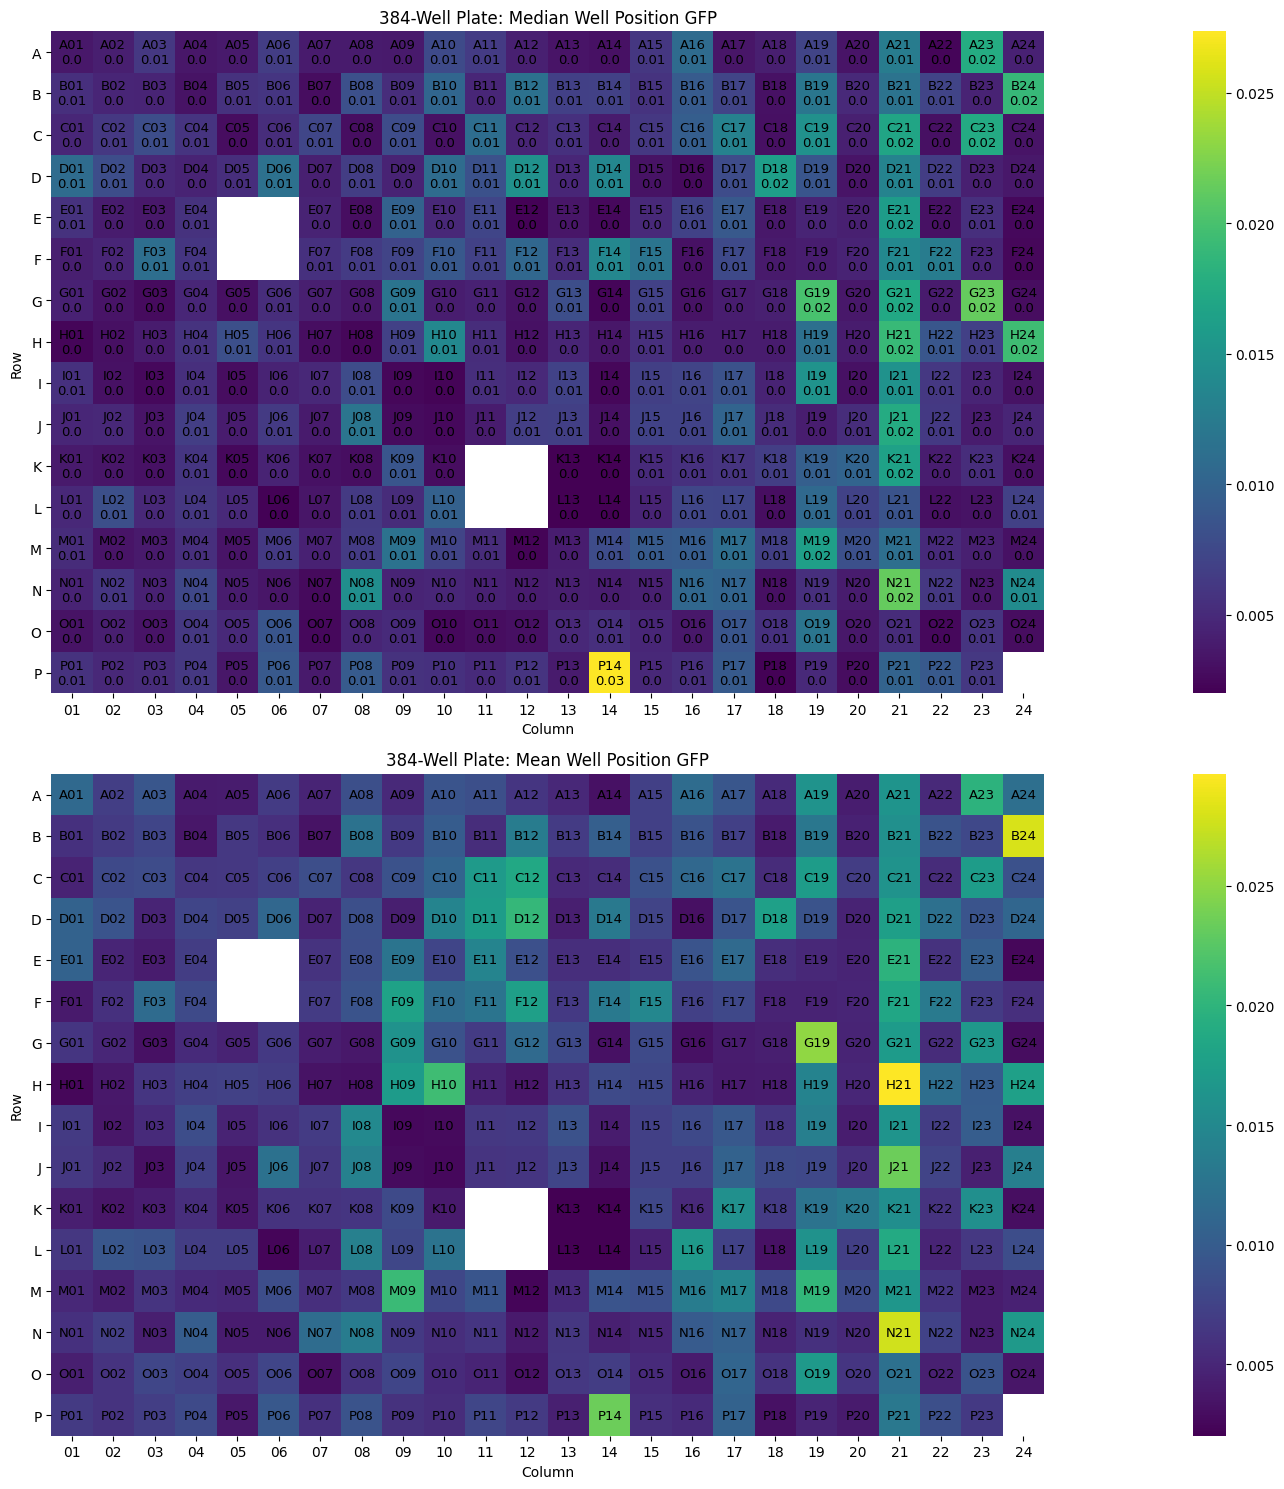

In [12]:
median_well_profile = well_profiles.group_by("Metadata_Well").agg(
    pl.col(GFP_FEAT).median().alias("GFP")
).with_columns(
    pl.col("Metadata_Well").alias("gene_allele")
)
mean_well_profile = well_profiles.group_by("Metadata_Well").agg(
    pl.col(GFP_FEAT).mean().alias("GFP")
).with_columns(
    pl.col("Metadata_Well").alias("gene_allele")
)

plt.clf()
fig, axes = plt.subplots(2,1,figsize=(30,15)) ## sharey=True,sharex=True
plot_platemap(
    median_well_profile,
    "Median Well Position GFP",
    well_pos_col="Metadata_Well",
    # this is the column to color by (categorical or continuous)
    value_col="GFP",
    # these columns will be concatenated into the annotation text
    label_cols=("gene_allele","GFP"),
    ax=axes[0], #[plates.index(plate)//2, plates.index(plate)%2],
    value_type="continuous",   # or "continuous"
    continuous_cmap="viridis",  # matplotlib colormap for continuous mode
    grid_square=None
)
plot_platemap(
    mean_well_profile,
    "Mean Well Position GFP",
    well_pos_col="Metadata_Well",
    # this is the column to color by (categorical or continuous)
    value_col="GFP",
    # these columns will be concatenated into the annotation text
    label_cols=("gene_allele",),
    ax=axes[1], #[plates.index(plate)//2, plates.index(plate)%2],
    value_type="continuous",   # or "continuous"
    continuous_cmap="viridis",  # matplotlib colormap for continuous mode
    grid_square=None
)

fig.subplots_adjust(wspace=-.55, hspace=.05)
plt.tight_layout()
plt.show()

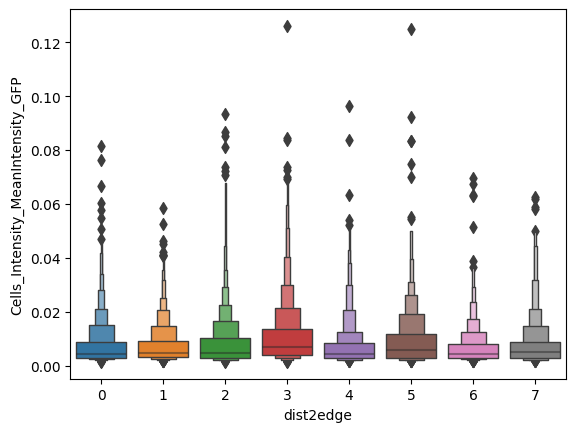

In [15]:
sns.boxenplot(data=well_profiles.with_columns(
    pl.col("Metadata_Well").map_elements(lambda x: well_to_coordinates(x)[1], return_dtype=pl.Int16).alias("well_row"),
    pl.col("Metadata_Well").map_elements(lambda x: well_to_coordinates(x)[2], return_dtype=pl.Int16).alias("well_col")
).with_columns(
    pl.struct(["well_row", "well_col"])
      .map_elements(lambda s: compute_distance(s["well_row"], s["well_col"]), return_dtype=pl.Int16)
      .alias("dist2edge")
).to_pandas(), x="dist2edge", y=GFP_FEAT)
plt.show()

## 3. Calculate abundance hits

Use paired t-test to call abundance hits

In [28]:
from scipy.stats import shapiro
import re
from scipy.stats import wilcoxon
from scipy.stats import ttest_rel, ttest_ind
import pandas as pd


# Convert letter rows to numbers
def well_to_coordinates(well):
    row_letter, col_number = re.match(r"([A-P])(\d{2})", well).groups()
    row_index = ord(row_letter) - ord('A') + 1  # Convert 'A'->1, 'B'->2, ..., 'P'->16
    col_index = int(col_number)  # Convert string column to integer
    return well, row_index, col_index


# Compute distances from edges and find the most centered well
def compute_distance(row, col):
    return min(row - 1, 16 - row, col - 1, 24 - col)  # Distance from nearest edge


## Abundance recalculation test: by Cell MeanIntensity
def paired_ttest(dat, reference: str, var: str, intensity_type: str=GFP_FEAT):
    # pivot to wide: one row per plate
    wide_gfp = dat.pivot(index="Metadata_Plate",
                        columns="Metadata_gene_allele",
                        values=intensity_type)
    # drop any plate that doesn’t have both measurements
    wide_gfp = wide_gfp.dropna(subset=[reference, var])
    if wide_gfp.shape[0] >= 3:
        # now run paired t-test
        t_stat, p_val = ttest_rel(wide_gfp[reference], wide_gfp[var])
    else:
        t_stat, p_val = None, None

    # ## perform stat test
    # dat = dat.dropna().sort_values(["Metadata_Plate","Metadata_gene_allele"])
    # # Assuming well_abun_stats is a DataFrame with columns 'reference_abundance' and 'variant_abundance'
    # reference_abundance = dat[dat["Metadata_gene_allele"]==reference][intensity_type].values
    # variant_abundance = dat[dat["Metadata_gene_allele"]==var][intensity_type].values
    # t_stat, p_val = ttest_rel(variant_abundance, reference_abundance)
    
    # Calculate Cohen's d
    mean_diff = np.mean(wide_gfp[var]) - np.mean(wide_gfp[reference])
    pooled_std = np.sqrt((np.std(wide_gfp[var], ddof=1) ** 2 + np.std(wide_gfp[reference], ddof=1) ** 2) / 2)
    cohen_d = mean_diff / pooled_std

    summary_df = pl.DataFrame(
        {
            "t_stat": t_stat,
            "p_val": p_val,
            "cohen_d": cohen_d
        }
    )
    summary_df = summary_df.with_columns(
        pl.lit(reference).alias("Gene"), pl.lit(var).alias("Variant")
    )
    return summary_df


def ind_ttest(dat, reference: str, var: str, intensity_type: str=GFP_FEAT):
    ## Per each ref-var well pair on the SAME plate, train and test the classifier
    ## sort the wells to make sure they are from the same plate
    df_sampled = pd.DataFrame()
    for plate in dat["Metadata_Plate"].unique():
        dat = dat[dat["Metadata_Plate"]==plate].dropna().sort_values(["Metadata_gene_allele"])
        # count rows per group
        group_counts = dat.groupby("Metadata_gene_allele").size()
        min_count = group_counts.min()
        # print("Minimum rows in any group:", min_count)
        shuffled = dat.sample(frac=1, random_state=42).reset_index(drop=True)
        # Then take the first min_count rows per group
        sampled_df2 = (
            shuffled
            .groupby("Metadata_gene_allele", group_keys=False)
            .head(min_count)
        )
        df_sampled = pd.concat([df_sampled, sampled_df2])

    # m0 = smf.ols("Cell_count ~ Metadata_Well", data=df_sampled).fit()
    # df_sampled["resid"] = m0.resid
    # print(df_sampled)
    ## require at least two alleles per each VAR and WT group
    if df_sampled.shape[0] >= 4:
        # now run paired t-test
        t_stat, p_val = ttest_ind(df_sampled.loc[df_sampled["Metadata_gene_allele"]==reference, intensity_type].values, 
                                  df_sampled.loc[df_sampled["Metadata_gene_allele"]==allele, intensity_type].values,
                                  equal_var=False)
        # res_t_stat, res_p_val = ttest_ind(df_sampled.loc[df_sampled["Metadata_gene_allele"]==reference, "resid"].values, 
        #                                   df_sampled.loc[df_sampled["Metadata_gene_allele"]==allele, "resid"].values,
        #                                   equal_var=False)
        # Calculate Cohen's d
        mean_diff = np.mean(df_sampled.loc[df_sampled["Metadata_gene_allele"]==reference, intensity_type].values) - \
                    np.mean(df_sampled.loc[df_sampled["Metadata_gene_allele"]==allele, intensity_type].values)
        pooled_std = np.sqrt((np.std(df_sampled.loc[df_sampled["Metadata_gene_allele"]==allele, intensity_type].values, ddof=1) ** 2 + \
                              np.std(df_sampled.loc[df_sampled["Metadata_gene_allele"]==reference, intensity_type].values, ddof=1) ** 2) / 2)
        cohen_d = mean_diff / pooled_std
    else:
        t_stat, p_val, cohen_d = None, None, None
        # res_t_stat, res_p_val = None, None

    # break
    summary_df = pl.DataFrame(
        {
            "t_stat": t_stat,
            "p_val": p_val,
            "cohen_d": cohen_d
        }
    )
    summary_df = summary_df.with_columns(
        pl.lit(reference).alias("Gene"), pl.lit(var).alias("Variant")
    )
    return summary_df

In [30]:
well_abun_stats = []

for allele in tqdm(well_profiles.select(pl.col("Metadata_gene_allele")).to_pandas()["Metadata_gene_allele"].unique()):
    if allele is None or allele.split("_")[0] == allele or allele not in tested_variants:
        continue

    reference = allele.split("_")[0]
    temp_prof_var = well_profiles.filter(
        (pl.col("Metadata_gene_allele") == allele) | (pl.col("Metadata_gene_allele") == reference)
    ).select(
        pl.col(["Metadata_gene_allele","Metadata_Plate","Metadata_Well",GFP_FEAT,"median_plate","Metadata_Bio_Batch"])
    ).to_pandas()

    ## subtract plate background
    temp_prof_var[GFP_FEAT] = temp_prof_var[GFP_FEAT] - temp_prof_var["median_plate"]

    bio_batch_list = list(temp_prof_var["Metadata_Bio_Batch"].unique())
    # if (len(bio_batch_list) > 1):
    #     print(bio_batch_list)
    #     print(allele)
        # print(temp_prof_var)
    for bio_batch in bio_batch_list:
        temp_prof = temp_prof_var[temp_prof_var["Metadata_Bio_Batch"]==bio_batch]
        if (temp_prof["Metadata_gene_allele"].unique().shape[0] < 2):
            # print(temp_prof)
            continue

        var_profiles = temp_prof[temp_prof["Metadata_gene_allele"]==allele]
        ref_profiles = temp_prof[(temp_prof["Metadata_gene_allele"]==reference)&(temp_prof["Metadata_Plate"].isin(var_profiles["Metadata_Plate"].unique()))]
        temp_prof = pd.concat([var_profiles, ref_profiles])

        if (bio_batch == "B_11-12"):
            ind_t_res = ind_ttest(
                dat=temp_prof,
                reference=reference,
                var=allele
            ).with_columns(
                pl.lit("").alias("Ref_well"),
                pl.lit("").alias("Var_well"),
                pl.lit(bio_batch).alias("Bio_Batch")
            )
            well_abun_stats.append(
                ind_t_res
            )
        else:
            ref_wells = ref_profiles["Metadata_Well"].unique()
            var_wells = var_profiles["Metadata_Well"].unique()
            ref_var_pairs = [(ref_well, var_well) for ref_well in ref_wells for var_well in var_wells]
            # display(temp_prof)
            
            ## Per each ref-var well pair on the SAME plate, train and test the classifier
            for ref_var in ref_var_pairs:
                ## sort the wells to make sure they are from the same plate
                df_sampled = temp_prof[temp_prof["Metadata_Well"].isin(ref_var)].dropna().sort_values(["Metadata_Plate","Metadata_gene_allele"])
                # display(df_sampled)
                paired_t_res = paired_ttest(
                    dat=df_sampled,
                    reference=reference,
                    var=allele
                ).with_columns(
                    pl.lit(ref_var[0]).alias("Ref_well"),
                    pl.lit(ref_var[1]).alias("Var_well"),
                    pl.lit(bio_batch).alias("Bio_Batch")
                )
                well_abun_stats.append(
                    paired_t_res
                )

well_abun_stats = pl.concat(well_abun_stats, how="vertical")
well_abun_stats = well_abun_stats.rename({"t_stat": "U2OS_t"})
well_abun_stats = well_abun_stats.sort(["Gene", "Variant", "U2OS_t", "p_val", "cohen_d"])
well_abun_stats

100%|██████████| 1081/1081 [00:04<00:00, 241.07it/s]


U2OS_t,p_val,cohen_d,Gene,Variant,Ref_well,Var_well,Bio_Batch
f64,f64,f64,str,str,str,str,str
4.020407,0.005057,-0.00036,"""AGXT""","""AGXT_Ala186Val""","""E07""","""M13""","""B_7-8"""
-1.799485,0.169768,0.003018,"""AGXT""","""AGXT_Ala248Ser""","""E07""","""O13""","""B_7-8"""
1.115418,0.301494,-0.000138,"""AGXT""","""AGXT_Ala248Val""","""E07""","""G15""","""B_7-8"""
1.427371,0.196523,-0.000175,"""AGXT""","""AGXT_Ala280Val""","""E07""","""A11""","""B_7-8"""
-3.109997,0.017081,0.000271,"""AGXT""","""AGXT_Ala295Thr""","""E07""","""E17""","""B_7-8"""
…,…,…,…,…,…,…,…
2.101618,0.073695,-0.000419,"""UBQLN2""","""UBQLN2_Pro497Ser""","""J13""","""B15""","""B_7-8"""
-1.156265,0.285506,0.000334,"""UBQLN2""","""UBQLN2_Pro509Ser""","""J13""","""D15""","""B_7-8"""
-1.052732,0.327441,0.000211,"""UBQLN2""","""UBQLN2_Pro525Ser""","""J13""","""F15""","""B_7-8"""


## 3. Summarize Results

In [32]:
## drop the null alleles
well_abun_stats = well_abun_stats.drop_nulls(subset="U2OS_t")

## extract the alleles with only single appearance
variants_single = well_abun_stats.group_by("Variant").len().filter(pl.col("len")==1)["Variant"]
well_abun_stats_single = well_abun_stats.filter(pl.col("Variant").is_in(variants_single))

## extract the alleles with replicates
variants_replicate = well_abun_stats.group_by("Variant").len().filter(pl.col("len")>1).unique(subset="Variant")["Variant"]
well_abun_stats_rep = well_abun_stats.filter(pl.col("Variant").is_in(variants_replicate))

## check the consistency between replicates
well_abun_stats_rep_group = well_abun_stats_rep.group_by("Variant").agg(
    pl.len().alias("count"),
    (pl.col("U2OS_t")>0).sum().alias("desc"),
    (pl.col("U2OS_t")<0).sum().alias("incr")
)
inconsistent_alleles = well_abun_stats_rep_group.filter((pl.col("count")!=pl.col("desc"))&(pl.col("count")!=pl.col("incr")))["Variant"].unique()
display(well_abun_stats_rep_group.filter((pl.col("count")!=pl.col("desc"))&(pl.col("count")!=pl.col("incr"))))

## No problem them merge by mean
well_abun_stats_rep = well_abun_stats_rep.group_by(["Gene","Variant"]).agg(
    pl.col("U2OS_t").mean().alias("U2OS_t"),
    pl.col("p_val").mean().alias("p_val")
).with_columns(
    pl.when(pl.col("Variant").is_in(inconsistent_alleles))
    .then(pl.lit(1))
    .otherwise(pl.col("p_val"))
    .alias("manual_adj_pval")
)

Variant,count,desc,incr
str,u32,u32,u32
"""MVK_Pro288Leu""",2,1,1
"""AGXT_Phe152Ile""",2,1,1
"""SMAD3_Thr261Ile""",2,1,1
"""GRN_Ala324Thr""",2,1,1


In [34]:
well_abun_stats_final = pl.concat([
    well_abun_stats_rep,
    well_abun_stats_single.with_columns(
        pl.col("p_val").alias("manual_adj_pval")
    ).select(pl.col(well_abun_stats_rep.columns))
])

well_abun_stats_final = well_abun_stats_final.rename({"U2OS_t": "U2OS_t_stat", "manual_adj_pval": "U2OS_t_pval"})
well_abun_stats_final = well_abun_stats_final.select(["Gene", "Variant", "U2OS_t_stat", "U2OS_t_pval"]) ## , "U2OS_paired_tstat_edgedist_resid", "U2OS_t_edgedist_resid_pval",

In [36]:
# Total number of increase vs. decrease
total = well_abun_stats_final.shape[0]

## We are comparing REF - VAR in the paired_ttest ttest_rel
## The t-statistic is calculated as np.mean(a - b)/se, where se is the standard error.
## Thus, t-stat > 0 means REF more than VAR --> VAR decreasing CC
per_dec = well_abun_stats_final.filter(pl.col("U2OS_t_stat") > 0).shape[0]
per_inc = well_abun_stats_final.filter(pl.col("U2OS_t_stat") < 0).shape[0]

print("Total decreasin vs increasing percent:")
print(f"{per_dec} {per_dec / total * 100:.2f} %")
print(f"{per_inc} {per_inc / total * 100:.2f} %")

dec_sig = well_abun_stats_final.filter(pl.col("U2OS_t_pval") < 0.05).filter(pl.col("U2OS_t_stat") > 0).shape[0]
inc_sig = well_abun_stats_final.filter(pl.col("U2OS_t_pval") < 0.05).filter(pl.col("U2OS_t_stat") < 0).shape[0]

print("Number sig decreases")
print(dec_sig)
print("Number sig increases")
print(inc_sig)

Total decreasin vs increasing percent:
387 54.51 %
323 45.49 %
Number sig decreases
278
Number sig increases
179


In [37]:
well_abun_stats_final.sort(by="U2OS_t_stat", descending=True)

Gene,Variant,U2OS_t_stat,U2OS_t_pval
str,str,f64,f64
"""SFTPA2""","""SFTPA2_Ala91Pro""",40.768434,0.000601
"""PHYH""","""PHYH_Arg275Gln""",27.319511,0.000011
"""STXBP1""","""STXBP1_Gly544Asp""",23.043994,0.00013
"""APOA1""","""APOA1_Leu114Pro""",20.289822,1.7703e-7
"""KCNJ2""","""KCNJ2_Pro420Leu""",19.019992,0.000001
…,…,…,…
"""MLH1""","""MLH1_Ser44Phe""",-19.78505,0.000013
"""GFAP""","""GFAP_Lys236Thr""",-21.827101,1.0693e-7
"""GFAP""","""GFAP_Arg79Ser""",-23.688251,6.0714e-8


In [38]:
well_abun_stats_final.write_csv(f"{CLASS_RES_OUTDIR}/well-level_prot-abundance_changes.csv")

### 3.1 ClinVar analysis

In [39]:
clin_var_annot_df = pl.read_csv("../../../../../../4_compare_AI_scores/3_outputs/varchamp_consolidated_alleles_clinvar_gnomad_dbnsfp_scores.tsv", 
                                separator="\t", infer_schema_length=10000)
clin_var_annot_df = clin_var_annot_df.with_columns(
    pl.concat_str([pl.col("symbol"), pl.col("aa_change")], separator="_").alias("gene_allele")
)
# allele_meta_df = allele_meta_df.join(
#     clin_var_annot_df.with_columns(
#         pl.concat_str([pl.col("symbol"), pl.col("aa_change")], separator="_").alias("gene_allele")
#     ),
#     on="gene_allele",
#     how="left"
# )
# allele_meta_df

In [40]:
well_abun_stats_final_clinvar = well_abun_stats_final.join(
    clin_var_annot_df.select(pl.col(["gene_allele", "clinvar_clnsig_clean_dbnsfp"])), 
    left_on="Variant",
    right_on="gene_allele",
    how="inner"
).with_columns(
    (np.sign(pl.col("U2OS_t_stat")) * np.log10(abs(pl.col("U2OS_t_stat")))).alias("-log10(t-stats)")
).drop_nulls(subset="clinvar_clnsig_clean_dbnsfp")

<Figure size 640x480 with 0 Axes>

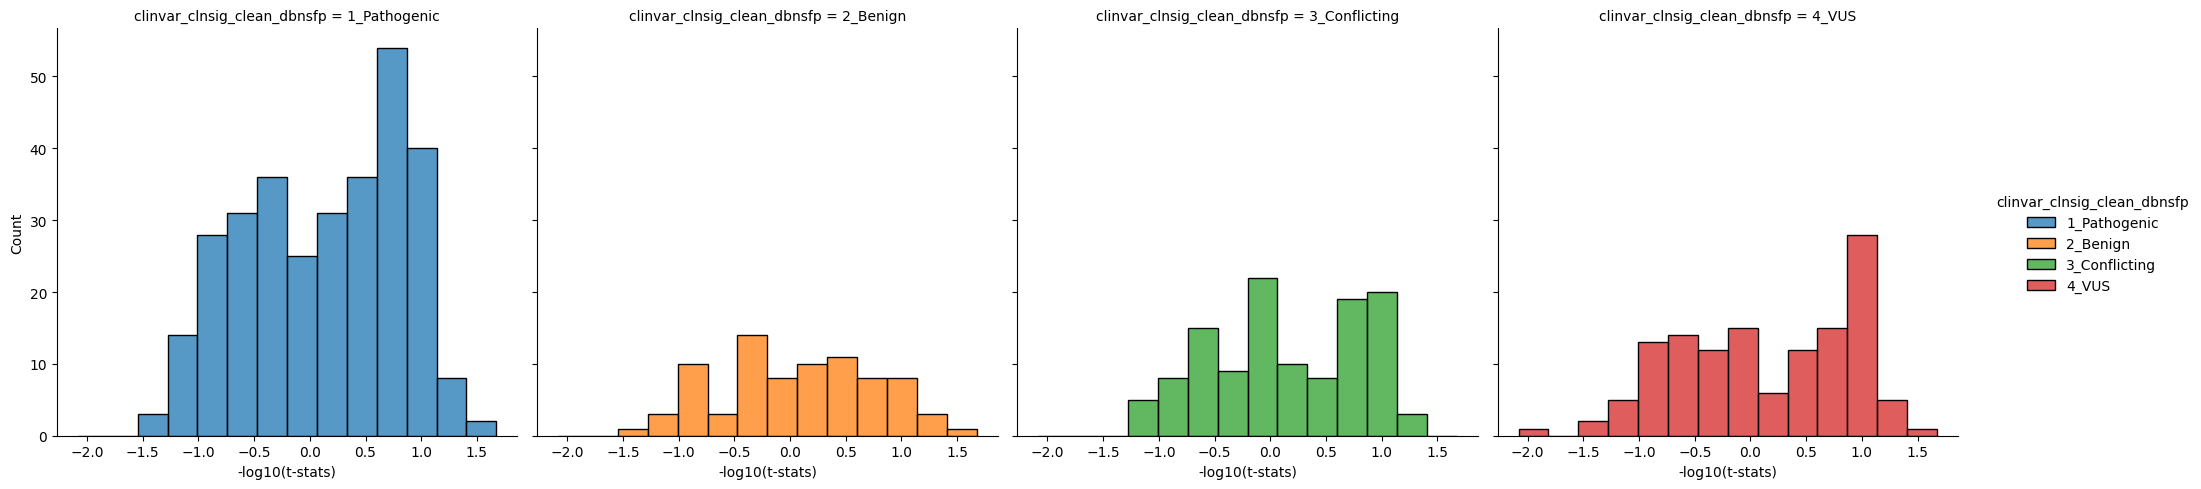

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.clf()
sns.displot(
    data=well_abun_stats_final_clinvar.filter(pl.col("clinvar_clnsig_clean_dbnsfp")!="5_Others").to_pandas().sort_values("clinvar_clnsig_clean_dbnsfp"),
    x="-log10(t-stats)",
    hue="clinvar_clnsig_clean_dbnsfp",
    col="clinvar_clnsig_clean_dbnsfp"
)
plt.show()

## 4. Visualize Imaging Wells

In [50]:
# allele_meta_df_dict["2025_03_Batch_15-16"].filter(pl.col("gene_allele")=="SFTPA2_Ala91Pro")

plate_map_name,well_position,symbol,gene_allele,source_plate,source_well,source_numb,dest_plate,dest_well,dest_numb,imaging_well,imaging_plate_R1,imaging_plate_R2,node_type,orf_id_wt,nt_change_cdna,aa_change,ccsb_mutation_id,hgmd_ID,clinvar_allele_ID,clinvar_clinical_significance,sequencing_confidence,gene,allele,final_gene_allele,gene_symbol,plate_map
str,str,str,str,str,str,f64,str,str,i64,str,str,str,str,f64,str,str,f64,str,str,str,str,str,str,str,str,str
"""B16A1A2_P1""","""D09""","""SFTPA2""","""SFTPA2_Ala91Pro""","""FV_reLR_02""","""F10""",78.0,"""FVrry_P05_Q03""","""B05""",34,"""D09""","""B15A1A2P1_R1""","""B16A1A2P1_R2""","""allele""",56023.0,"""271G>C""","""Ala91Pro""",31341.0,null,null,null,"""low""","""SFTPA2""","""Ala91Pro""","""SFTPA2_Ala91Pro""","""SFTPA2""","""B16A1A2_P1"""


<Figure size 640x480 with 0 Axes>

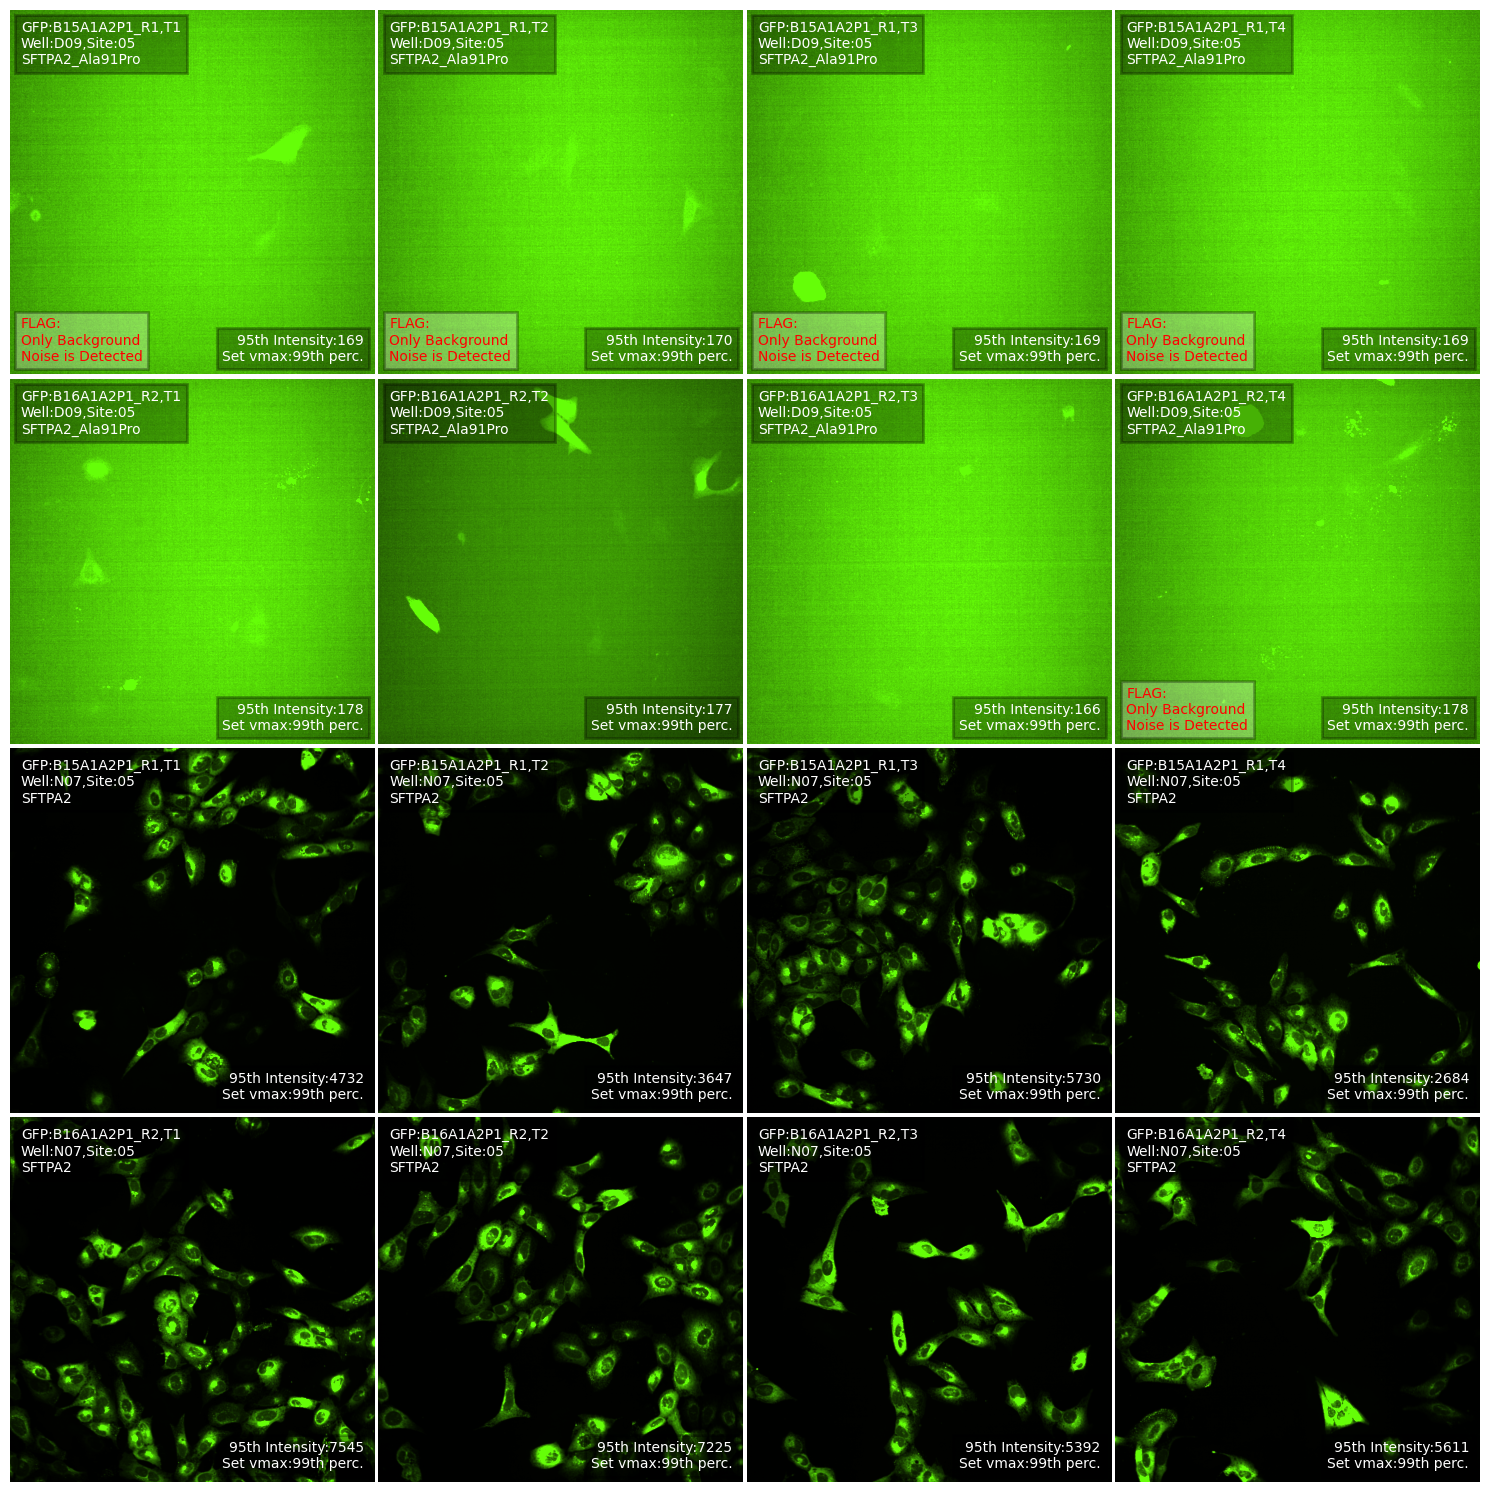

In [51]:
TIFF_IMGS_DIR = "../1.image_preprocess_qc/inputs/cpg_imgs"
OUT_IMGS_DIR = ""

plot_allele(allele_meta_df_dict["2025_03_Batch_15-16"], "SFTPA2_Ala91Pro", "GFP", 
            plate_img_qc=img_well_qc_sum_dict["2025_03_Batch_15-16"],
            site="05", max_intensity=0.99, display=True, imgs_dir=TIFF_IMGS_DIR)